In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


*TRYING cardiffnlp/twitter-roberta-base-sentiment*

In [2]:
pip install transformers

In [3]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import numpy as np
from scipy.special import softmax
from scipy.spatial.distance import jensenshannon
import os
import urllib.request
import csv
import matplotlib.pyplot as plt
import shutil
import matplotlib.pyplot as plt
import seaborn as sns

# **Mean JSD Calculations**

In [4]:
task = 'sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
tokenizer = AutoTokenizer.from_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [5]:
labels = []
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
    labels = [row[1] for row in csvreader if len(row) > 1]

In [6]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.eval()

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [7]:
def classify_sentiment(sentences):
    all_sentiment_scores = []
    for sent in sentences:
        encoded_input = tokenizer(sent, return_tensors='pt')
        output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        probabilities = softmax(scores)
        all_sentiment_scores.append(probabilities)
    return all_sentiment_scores

In [8]:
def calculate_jsd(p, q):
    return jensenshannon(p, q)

In [9]:
def process_file(file_path, common_files):
    file_name = os.path.basename(file_path)
    if file_name not in common_files:
        return None, None  # Skip files not in the common files list

    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()

        if not lines:
            return None, None  # Handle empty files

        jsd_values = []  # Store JSD values for each sentence pair

        for line in lines:
            if '---->' in line:
                left, right = line.split('---->', 1)
                left = left.strip()
                right = right.strip()

                # Process sentiment for each sentence
                left_sentiment = classify_sentiment([left])[0]
                right_sentiment = classify_sentiment([right])[0]

                # Calculate JSD for the pair and append to list
                jsd = calculate_jsd(left_sentiment, right_sentiment)
                jsd_values.append(jsd)

        if not jsd_values:
            return None, None  # If no JSD values were calculated, return None

        mean_jsd = np.mean(jsd_values)  # Calculate mean JSD for the file
        return mean_jsd, file_path if mean_jsd > 0.3 else None
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None, None


In [10]:
# def process_file(file_path, common_files):
#     file_name = os.path.basename(file_path)
#     if file_name not in common_files:
#         return None, None

#     try:
#         with open(file_path, 'r') as file:
#             lines = file.readlines()

#         if not lines:
#             return None, None

#         left_sents = [line.split('---->')[0].strip() for line in lines if '---->' in line]
#         right_sents = [line.split('---->')[1].strip() for line in lines if '---->' in line]

#         if not left_sents or not right_sents:
#             return None, None

#         left_sentiments = classify_sentiment(left_sents)
#         right_sentiments = classify_sentiment(right_sents)

#         jsd_values = [calculate_jsd(p, q) for p, q in zip(left_sentiments, right_sentiments)]

#         if not jsd_values:
#             return None, None

#         mean_jsd = np.mean(jsd_values)
#         return mean_jsd, file_path if mean_jsd > 0.3 else None
#     except Exception as e:
#         print(f"Error processing file {file_path}: {e}")
#         return None, None

In [11]:
def find_common_files(mock_folder):
    subfolder_files = []
    for subfolder in os.listdir(mock_folder):
        subfolder_path = os.path.join(mock_folder, subfolder)
        if os.path.isdir(subfolder_path):
            files = {file for file in os.listdir(subfolder_path) if file.endswith("_translated.txt")}
            if files:
                subfolder_files.append(files)

    # Find the intersection of all file sets
    common_files = set.intersection(*subfolder_files) if subfolder_files else set()
    return common_files

In [12]:
def process_subfolder(subfolder_path, common_files, target_folder):
    mean_jsds = []
    for file in os.listdir(subfolder_path):
        if file in common_files:
            mean_jsd, file_to_copy = process_file(os.path.join(subfolder_path, file), common_files)
            if mean_jsd is not None:
                mean_jsds.append(mean_jsd)
            if file_to_copy:
                shutil.copy(file_to_copy, target_folder)

    return np.mean(mean_jsds) if mean_jsds else None

## ***Overall Mean JSD***

In [13]:
mock_folder = '/content/drive/MyDrive/thesis-data/Translated_Articles-LASER2-final'
common_files = find_common_files(mock_folder)
target_folder = '/content/drive/MyDrive/thesis-data/JSD>0.3-final_revised'  # Replace with your actual target folder
os.makedirs(target_folder, exist_ok=True)

In [14]:
# mock_folder = '/content/drive/MyDrive/thesis-data/lol'
# common_files = find_common_files(mock_folder)
# target_folder = '/content/drive/MyDrive/thesis-data/JSD>0.3-final_revised_lol'  # Replace with your actual target folder
# os.makedirs(target_folder, exist_ok=True)

In [15]:
print("Count of common files across all subfolders:", len(common_files))

Count of common files across all subfolders: 243


In [16]:
subfolder_jsd_results = {}
for subfolder in os.listdir(mock_folder):
    subfolder_path = os.path.join(mock_folder, subfolder)
    if os.path.isdir(subfolder_path):
        mean_jsd_subfolder = process_subfolder(subfolder_path, common_files, target_folder)
        if mean_jsd_subfolder is not None:
            language_pair = '-'.join(subfolder.split('_')[2:4])
            subfolder_jsd_results[language_pair] = mean_jsd_subfolder
            print(f"Mean JSD for {language_pair}: {mean_jsd_subfolder:.8f}")


Mean JSD for En-Af: 0.13548943
Mean JSD for Zh-Hi: 0.15785402
Mean JSD for Af-Zh: 0.16163874
Mean JSD for En-Zh: 0.14901249
Mean JSD for En-Hi: 0.13062651
Mean JSD for Af-Hi: 0.14111231
Mean JSD for En-Ro: 0.03833706


<ipython-input-25-5241b8b262d8>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, palette="coolwarm")


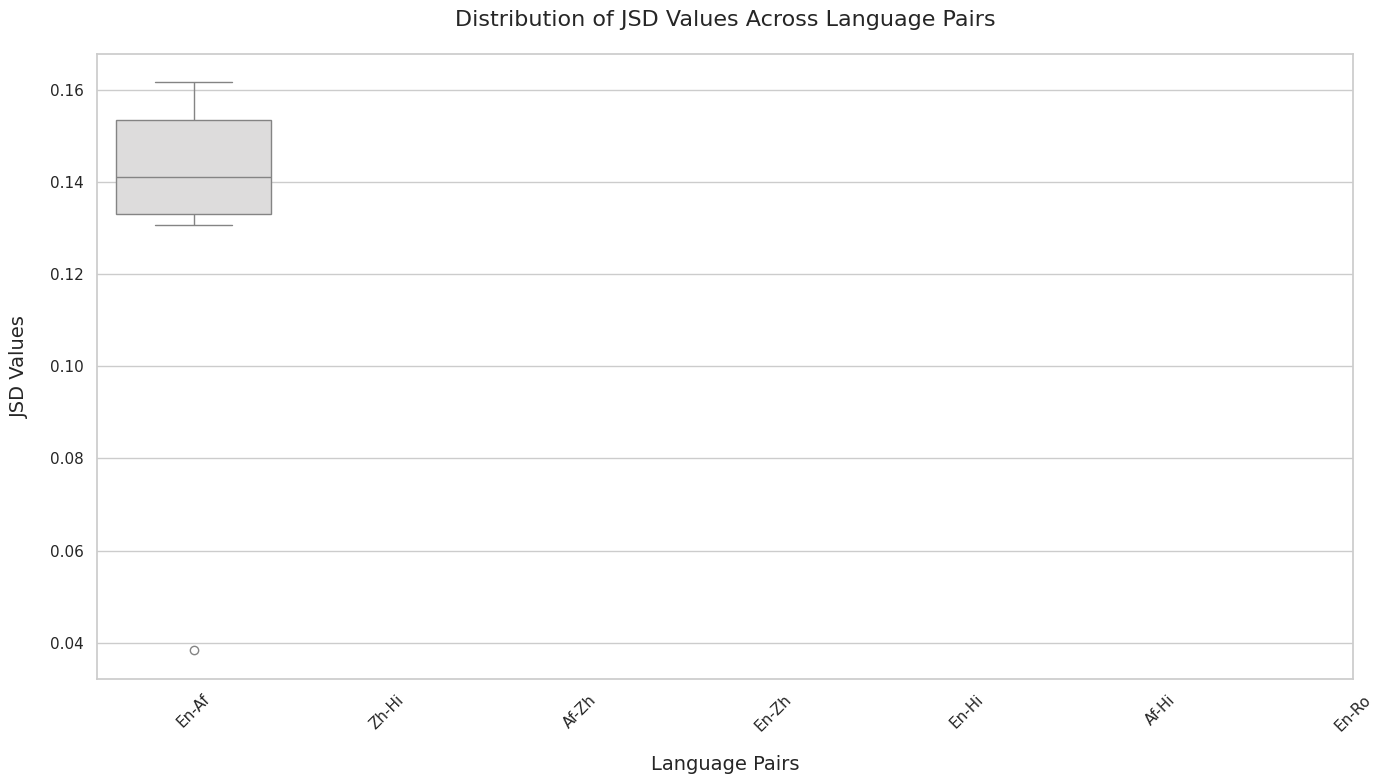

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use Seaborn for a nicer look
sns.set(style="whitegrid")

# Prepare data for the box plot
labels, data = zip(*subfolder_jsd_results.items())

plt.figure(figsize=(14, 8))  # Larger figure size for better visibility

# Create the box plot with Seaborn's color palette
sns.boxplot(data=data, palette="coolwarm")
plt.xticks(range(len(labels)), labels, rotation=45)

# Adding labels and title
plt.xlabel('Language Pairs', fontsize=14, labelpad=15)
plt.ylabel('JSD Values', fontsize=14, labelpad=15)
plt.title('Distribution of JSD Values Across Language Pairs', fontsize=16, pad=20)


plt.tight_layout()  # Adjust layout
plt.show()

Wait

## ***Mean JSD Categorically***

In [33]:
import pandas as pd

# Load CSV files
controv_df = pd.read_csv('/content/drive/MyDrive/thesis-data/controvlist.csv')
wars_df = pd.read_csv('/content/drive/MyDrive/thesis-data/warslist.csv')

controv_ids = controv_df['Wikidata ID'].apply(lambda x: f"{x}_translated.txt").tolist()
wars_ids = wars_df['Wikidata ID'].apply(lambda x: f"{x}_translated.txt").tolist()

In [34]:
def process_subfolder(subfolder_path, common_ids, target_folder, results_dict):
    for file in os.listdir(subfolder_path):
        if file in common_ids:
            mean_jsd, file_to_copy = process_file(os.path.join(subfolder_path, file), common_ids)
            if file_to_copy:
                shutil.copy(file_to_copy, target_folder)
            if mean_jsd is not None:
                language_pair = '-'.join(subfolder_path.split('/')[-1].split('_')[2:4])
                if language_pair not in results_dict:
                    results_dict[language_pair] = []
                results_dict[language_pair].append(mean_jsd)

In [35]:
mock_folder = '/content/drive/MyDrive/thesis-data/Translated_Articles-LASER2-final'
target_folder = '/content/drive/MyDrive/thesis-data/JSD>0.3-categorically-final'
os.makedirs(target_folder, exist_ok=True)

common_files = find_common_files(mock_folder)

In [36]:
all_jsd_results_controv = {}
all_jsd_results_wars = {}

In [37]:
# Filter common files by controv_ids and wars_ids
common_controv_files = set(common_files).intersection(controv_ids)
common_wars_files = set(common_files).intersection(wars_ids)

In [38]:
for list_name, ids_list in [('controv', common_controv_files), ('wars', common_wars_files)]:
    results_dict = all_jsd_results_controv if list_name == 'controv' else all_jsd_results_wars
    for subfolder in os.listdir(mock_folder):
        subfolder_path = os.path.join(mock_folder, subfolder)
        if os.path.isdir(subfolder_path):
            process_subfolder(subfolder_path, ids_list, target_folder, results_dict)

In [39]:
# Function to print mean JSD for each language pair in a given results dictionary
def print_mean_jsd_for_language_pairs(results_dict, list_name):
    print(f"Mean JSD for {list_name} list:")
    for language_pair, jsd_values in results_dict.items():
        if jsd_values:  # Ensure there are JSD values to calculate the mean
            mean_jsd = np.mean(jsd_values)
            print(f"{language_pair}: {mean_jsd:.8f}")
        else:
            print(f"{language_pair}: No JSD values")
    print("\n")  # Print a newline for better separation

# Print mean JSD for each language pair for the 'controv' and 'wars' lists
print_mean_jsd_for_language_pairs(all_jsd_results_controv, "Controversial")
print_mean_jsd_for_language_pairs(all_jsd_results_wars, "Wars")

Mean JSD for Controversial list:
En-Af: 0.13770814
Zh-Hi: 0.15668781
Af-Zh: 0.16032550
En-Zh: 0.14902379
En-Hi: 0.13159298
Af-Hi: 0.13912605
En-Ro: 0.03774755


Mean JSD for Wars list:
En-Af: 0.10493234
Zh-Hi: 0.16940498
Af-Zh: 0.17058437
En-Zh: 0.15743938
En-Hi: 0.12554704
Af-Hi: 0.16597488
En-Ro: 0.04433531




In [ ]:
def create_box_plot(data_dict, title):
    sns.set(style="whitegrid")
    labels, data = zip(*[(k, v) for k, v in data_dict.items() if v])  # Filter out empty lists
    plt.figure(figsize=(14, 8))
    sns.boxplot(data=list(data), palette="coolwarm")
    plt.xticks(range(len(labels)), labels, rotation=45)
    plt.xlabel('Language Pairs', fontsize=14, labelpad=15)
    plt.ylabel('JSD Values', fontsize=14, labelpad=15)
    plt.title(title, fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

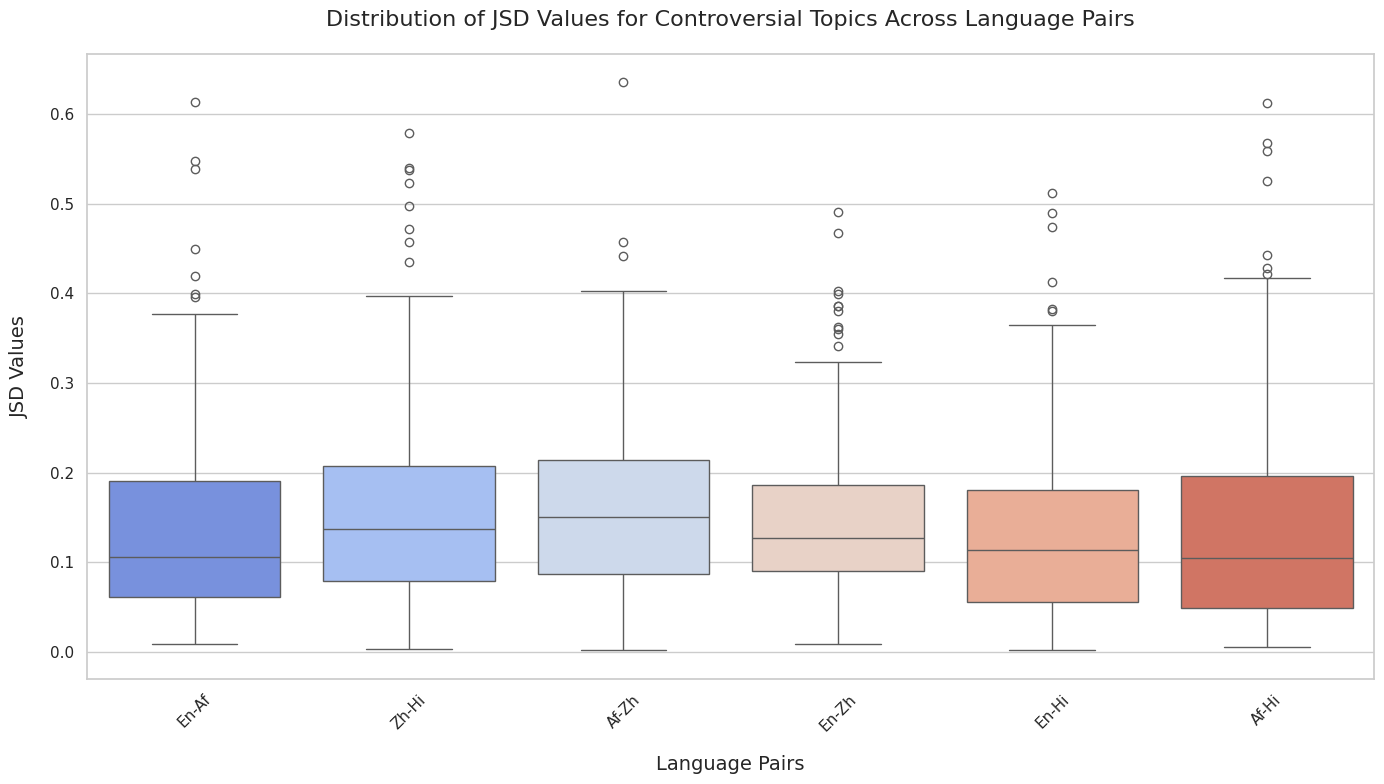

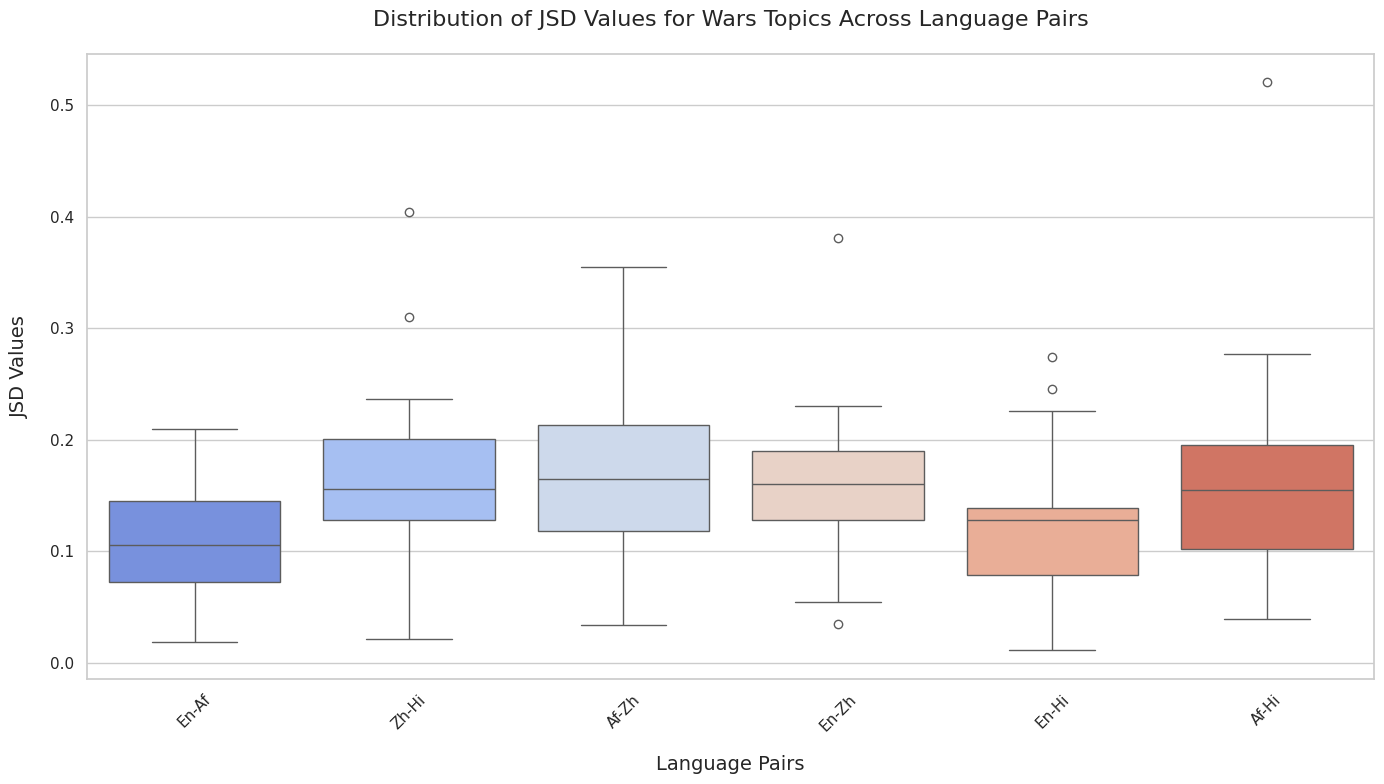

In [ ]:
create_box_plot(all_jsd_results_controv, 'Distribution of JSD Values for Controversial Topics Across Language Pairs')
create_box_plot(all_jsd_results_wars, 'Distribution of JSD Values for Wars Topics Across Language Pairs')

## **JSD Correlation with Sentence Difference Length**

## **With Document Boundary**

## ***Overall Results***

In [ ]:
import os
import numpy as np
import csv
import urllib.request
from scipy.special import softmax
from scipy.spatial.distance import jensenshannon
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Initialize model and tokenizer
task = 'sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.eval()

# Load labels for sentiment analysis
labels = []
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
    labels = [row[1] for row in csvreader if len(row) > 1]

# Function to classify sentiment
def classify_sentiment(sentences):
    all_sentiment_scores = []
    for sent in sentences:
        encoded_input = tokenizer(sent, return_tensors='pt')
        output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        probabilities = softmax(scores)
        all_sentiment_scores.append(probabilities)
    return all_sentiment_scores

# Function to calculate Jensen-Shannon Divergence
def calculate_jsd(p, q):
    return jensenshannon(p, q)

# Function to find common files across all subfolders
def find_common_files(directory):
    common_files = None
    for subfolder in os.listdir(directory):
        subfolder_path = os.path.join(directory, subfolder)
        if os.path.isdir(subfolder_path):
            current_files = set(f for f in os.listdir(subfolder_path) if f.endswith("_translated.txt"))
            if common_files is None:
                common_files = current_files
            else:
                common_files &= current_files
    return common_files if common_files else set()

# Function to process each file
def process_file(file_path):
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()

        if not lines:
            return [], []

        length_diffs = []
        jsd_values = []

        for line in lines:
            if '---->' in line:
                left, right = line.split('---->')
                left = left.strip()
                right = right.strip()

                left_sentiment = classify_sentiment([left])[0]
                right_sentiment = classify_sentiment([right])[0]

                jsd = calculate_jsd(left_sentiment, right_sentiment)
                jsd_values.append(jsd)

                length_diff = abs(len(left.split()) - len(right.split()))
                length_diffs.append(length_diff)

        return length_diffs, jsd_values
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return [], []

# Function to process all subfolders and calculate correlations
def process_all_subfolders(mock_folder):
    common_files = find_common_files(mock_folder)  # Get common files across all subfolders
    all_length_diffs = []
    all_jsd_values = []

    for subfolder in os.listdir(mock_folder):
        subfolder_path = os.path.join(mock_folder, subfolder)
        if os.path.isdir(subfolder_path):
            for file in os.listdir(subfolder_path):
                if file in common_files:  # Process only common files
                    file_path = os.path.join(subfolder_path, file)
                    length_diffs, jsd_values = process_file(file_path)
                    all_length_diffs.extend(length_diffs)
                    all_jsd_values.extend(jsd_values)

    return all_length_diffs, all_jsd_values

# Example usage
mock_folder = '/content/drive/MyDrive/thesis-data/Translated_Articles-LASER2-final'
all_length_diffs, all_jsd_values = process_all_subfolders(mock_folder)

# Calculate Pearson correlation coefficient
correlation = np.corrcoef(all_length_diffs, all_jsd_values)[0, 1]
print("Correlation between sentence length difference and JSD:", correlation)


Correlation between sentence length difference and JSD: 0.18253977177309635


## ***War Results***

In [ ]:
import os
import numpy as np
import csv
import urllib.request
from scipy.special import softmax
from scipy.spatial.distance import jensenshannon
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Initialize model and tokenizer
task = 'sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.eval()

# Load labels for sentiment analysis
labels = []
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
    labels = [row[1] for row in csvreader if len(row) > 1]

# Function to classify sentiment
def classify_sentiment(sentences):
    all_sentiment_scores = []
    for sent in sentences:
        encoded_input = tokenizer(sent, return_tensors='pt')
        output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        probabilities = softmax(scores)
        all_sentiment_scores.append(probabilities)
    return all_sentiment_scores

# Function to calculate Jensen-Shannon Divergence
def calculate_jsd(p, q):
    return jensenshannon(p, q)

# Function to find common files across all subfolders
def find_common_files(directory):
    common_files = None
    for subfolder in os.listdir(directory):
        subfolder_path = os.path.join(directory, subfolder)
        if os.path.isdir(subfolder_path):
            current_files = set(f for f in os.listdir(subfolder_path) if f.endswith("_translated.txt"))
            if common_files is None:
                common_files = current_files
            else:
                common_files &= current_files
    return common_files if common_files else set()

# Function to process each file
def process_file(file_path):
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()

        if not lines:
            return [], []

        length_diffs = []
        jsd_values = []

        for line in lines:
            if '---->' in line:
                left, right = line.split('---->')
                left = left.strip()
                right = right.strip()

                left_sentiment = classify_sentiment([left])[0]
                right_sentiment = classify_sentiment([right])[0]

                jsd = calculate_jsd(left_sentiment, right_sentiment)
                jsd_values.append(jsd)

                length_diff = abs(len(left.split()) - len(right.split()))
                length_diffs.append(length_diff)

        return length_diffs, jsd_values
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return [], []

# Function to process all subfolders and calculate correlations
def process_all_subfolders(mock_folder):
    common_files = find_common_files(mock_folder)  # Get common files across all subfolders
    all_length_diffs = []
    all_jsd_values = []

    for subfolder in os.listdir(mock_folder):
        subfolder_path = os.path.join(mock_folder, subfolder)
        if os.path.isdir(subfolder_path):
            for file in os.listdir(subfolder_path):
                if file in common_files:  # Process only common files
                    file_path = os.path.join(subfolder_path, file)
                    length_diffs, jsd_values = process_file(file_path)
                    all_length_diffs.extend(length_diffs)
                    all_jsd_values.extend(jsd_values)

    return all_length_diffs, all_jsd_values

# Example usage
mock_folder = '/content/drive/MyDrive/thesis-data/war_files'
all_length_diffs, all_jsd_values = process_all_subfolders(mock_folder)

# Calculate Pearson correlation coefficient
correlation = np.corrcoef(all_length_diffs, all_jsd_values)[0, 1]
print("Correlation between sentence length difference and JSD:", correlation)


Correlation between sentence length difference and JSD: 0.0632666400731104


## ***Controversial Results***

In [ ]:
import os
import numpy as np
import csv
import urllib.request
from scipy.special import softmax
from scipy.spatial.distance import jensenshannon
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Initialize model and tokenizer
task = 'sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.eval()

# Load labels for sentiment analysis
labels = []
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
    labels = [row[1] for row in csvreader if len(row) > 1]

# Function to classify sentiment
def classify_sentiment(sentences):
    all_sentiment_scores = []
    for sent in sentences:
        encoded_input = tokenizer(sent, return_tensors='pt')
        output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        probabilities = softmax(scores)
        all_sentiment_scores.append(probabilities)
    return all_sentiment_scores

# Function to calculate Jensen-Shannon Divergence
def calculate_jsd(p, q):
    return jensenshannon(p, q)

# Function to find common files across all subfolders
def find_common_files(directory):
    common_files = None
    for subfolder in os.listdir(directory):
        subfolder_path = os.path.join(directory, subfolder)
        if os.path.isdir(subfolder_path):
            current_files = set(f for f in os.listdir(subfolder_path) if f.endswith("_translated.txt"))
            if common_files is None:
                common_files = current_files
            else:
                common_files &= current_files
    return common_files if common_files else set()

# Function to process each file
def process_file(file_path):
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()

        if not lines:
            return [], []

        length_diffs = []
        jsd_values = []

        for line in lines:
            if '---->' in line:
                left, right = line.split('---->')
                left = left.strip()
                right = right.strip()

                left_sentiment = classify_sentiment([left])[0]
                right_sentiment = classify_sentiment([right])[0]

                jsd = calculate_jsd(left_sentiment, right_sentiment)
                jsd_values.append(jsd)

                length_diff = abs(len(left.split()) - len(right.split()))
                length_diffs.append(length_diff)

        return length_diffs, jsd_values
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return [], []

# Function to process all subfolders and calculate correlations
def process_all_subfolders(mock_folder):
    common_files = find_common_files(mock_folder)  # Get common files across all subfolders
    all_length_diffs = []
    all_jsd_values = []

    for subfolder in os.listdir(mock_folder):
        subfolder_path = os.path.join(mock_folder, subfolder)
        if os.path.isdir(subfolder_path):
            for file in os.listdir(subfolder_path):
                if file in common_files:  # Process only common files
                    file_path = os.path.join(subfolder_path, file)
                    length_diffs, jsd_values = process_file(file_path)
                    all_length_diffs.extend(length_diffs)
                    all_jsd_values.extend(jsd_values)

    return all_length_diffs, all_jsd_values

# Example usage
mock_folder = '/content/drive/MyDrive/thesis-data/controv_files'
all_length_diffs, all_jsd_values = process_all_subfolders(mock_folder)

# Calculate Pearson correlation coefficient
correlation = np.corrcoef(all_length_diffs, all_jsd_values)[0, 1]
print("Correlation between sentence length difference and JSD:", correlation)


Correlation between sentence length difference and JSD: 0.19064511396771583


In [ ]:
# import os
# import numpy as np
# import csv
# import urllib.request
# from scipy.special import softmax
# from scipy.spatial.distance import jensenshannon
# from transformers import AutoModelForSequenceClassification, AutoTokenizer

# # Initialize model and tokenizer
# task = 'sentiment'
# MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
# tokenizer = AutoTokenizer.from_pretrained(MODEL)
# model = AutoModelForSequenceClassification.from_pretrained(MODEL)
# model.eval()

# # Load labels for sentiment analysis
# labels = []
# mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
# with urllib.request.urlopen(mapping_link) as f:
#     html = f.read().decode('utf-8').split("\n")
#     csvreader = csv.reader(html, delimiter='\t')
#     labels = [row[1] for row in csvreader if len(row) > 1]

# # Function to classify sentiment
# def classify_sentiment(sentences):
#     all_sentiment_scores = []
#     for sent in sentences:
#         encoded_input = tokenizer(sent, return_tensors='pt')
#         output = model(**encoded_input)
#         scores = output[0][0].detach().numpy()
#         probabilities = softmax(scores)
#         all_sentiment_scores.append(probabilities)
#     return all_sentiment_scores

# # Function to calculate Jensen-Shannon Divergence
# def calculate_jsd(p, q):
#     return jensenshannon(p, q)

# # Function to find common files across all subfolders
# def find_common_files(directory):
#     common_files = None
#     for subfolder in os.listdir(directory):
#         subfolder_path = os.path.join(directory, subfolder)
#         if os.path.isdir(subfolder_path):
#             current_files = set(f for f in os.listdir(subfolder_path) if f.endswith("_translated.txt"))
#             if common_files is None:
#                 common_files = current_files
#             else:
#                 common_files &= current_files
#     return common_files if common_files else set()

# # Function to process each file
# def process_file(file_path):
#     try:
#         with open(file_path, 'r') as file:
#             lines = file.readlines()

#         if not lines:
#             return [], []

#         length_diffs = []
#         jsd_values = []

#         for line in lines:
#             if '---->' in line:
#                 left, right = line.split('---->')
#                 left = left.strip()
#                 right = right.strip()

#                 left_sentiment = classify_sentiment([left])[0]
#                 right_sentiment = classify_sentiment([right])[0]

#                 jsd = calculate_jsd(left_sentiment, right_sentiment)
#                 jsd_values.append(jsd)

#                 length_diff = abs(len(left.split()) - len(right.split()))
#                 length_diffs.append(length_diff)
#                 print(length_diffs)
#                 print(jsd_values)

#         return length_diffs, jsd_values
#     except Exception as e:
#         print(f"Error processing file {file_path}: {e}")
#         return [], []

# # Function to process all subfolders and calculate correlations
# def process_all_subfolders(mock_folder):
#     common_files = find_common_files(mock_folder)  # Get common files across all subfolders
#     all_length_diffs = []
#     all_jsd_values = []

#     for subfolder in os.listdir(mock_folder):
#         subfolder_path = os.path.join(mock_folder, subfolder)
#         if os.path.isdir(subfolder_path):
#             for file in os.listdir(subfolder_path):
#                 if file in common_files:  # Process only common files
#                     file_path = os.path.join(subfolder_path, file)
#                     length_diffs, jsd_values = process_file(file_path)
#                     all_length_diffs.extend(length_diffs)
#                     all_jsd_values.extend(jsd_values)

#     return all_length_diffs, all_jsd_values

# # Example usage
# mock_folder = '/content/drive/MyDrive/thesis-data/lol'
# all_length_diffs, all_jsd_values = process_all_subfolders(mock_folder)

# # Calculate Pearson correlation coefficient
# print("ggggggggggggggggggggggggggggggg")
# print(all_length_diffs)
# print((all_jsd_values))
# correlation = np.corrcoef(all_length_diffs, all_jsd_values)[0, 1]


# print("Correlation between sentence length difference and JSD:", correlation)


[0]
[0.8149885434825713]
[0, 0]
[0.8149885434825713, 0.7923104696745051]
[0, 0, 2]
[0.8149885434825713, 0.7923104696745051, 0.17694797087314645]
[0]
[0.03913644110614173]
[0, 0]
[0.03913644110614173, 0.04527372456411041]
[0, 0, 0]
[0.03913644110614173, 0.04527372456411041, 0.7872975316215747]
[0]
[0.8149344579401586]
[0, 2]
[0.8149344579401586, 0.7449695845930148]
[0, 2, 1]
[0.8149344579401586, 0.7449695845930148, 0.6004092569134436]
[0]
[0.8149885434825713]
[0, 0]
[0.8149885434825713, 0.7923104696745051]
ggggggggggggggggggggggggggggggg
[0, 0, 2, 0, 0, 0, 0, 2, 1, 0, 0]
[0.8149885434825713, 0.7923104696745051, 0.17694797087314645, 0.03913644110614173, 0.04527372456411041, 0.7872975316215747, 0.8149344579401586, 0.7449695845930148, 0.6004092569134436, 0.8149885434825713, 0.7923104696745051]
Correlation between sentence length difference and JSD: -0.17749066427506616


## **Subfolder Wise**

## ***Overall Results***

In [ ]:
import os
import numpy as np
import csv
import urllib.request
from scipy.special import softmax
from scipy.spatial.distance import jensenshannon
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from scipy.stats import pearsonr

# Initialize model and tokenizer
task = 'sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.eval()

# Load labels for sentiment analysis
labels = []
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
    labels = [row[1] for row in csvreader if len(row) > 1]

def classify_sentiment(sentences):
    all_sentiment_scores = []
    for sent in sentences:
        encoded_input = tokenizer(sent, return_tensors='pt')
        output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        probabilities = softmax(scores)
        all_sentiment_scores.append(probabilities)
    return all_sentiment_scores

def calculate_jsd(p, q):
    return jensenshannon(p, q)

def process_file(file_path):
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
        if not lines:
            return [], []

        length_diffs = []
        jsd_values = []
        for line in lines:
            if '---->' in line:
                left, right = line.split('---->')
                left = left.strip()
                right = right.strip()

                left_sentiment = classify_sentiment([left])[0]
                right_sentiment = classify_sentiment([right])[0]

                jsd = calculate_jsd(left_sentiment, right_sentiment)
                jsd_values.append(jsd)

                length_diff = abs(len(left.split()) - len(right.split()))
                length_diffs.append(length_diff)
        return length_diffs, jsd_values
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return [], []

def find_common_files(directory):
    common_files = None
    for subfolder in os.listdir(directory):
        subfolder_path = os.path.join(directory, subfolder)
        if os.path.isdir(subfolder_path):
            current_files = set(f for f in os.listdir(subfolder_path) if f.endswith("_translated.txt"))
            if common_files is None:
                common_files = current_files
            else:
                common_files &= current_files
    return common_files if common_files else set()

def process_subfolder(subfolder_path, common_files):
    all_length_diffs = []
    all_jsd_values = []

    for file in os.listdir(subfolder_path):
        if file in common_files:
            file_path = os.path.join(subfolder_path, file)
            length_diffs, jsd_values = process_file(file_path)
            all_length_diffs.extend(length_diffs)
            all_jsd_values.extend(jsd_values)

    if all_length_diffs and all_jsd_values:
        correlation, p_value = pearsonr(all_length_diffs, all_jsd_values)
        return all_length_diffs, all_jsd_values, correlation, p_value
    else:
        return all_length_diffs, all_jsd_values, None, None

def process_all_subfolders(mock_folder):
    common_files = find_common_files(mock_folder)
    subfolder_results = {}

    for subfolder in os.listdir(mock_folder):
        subfolder_path = os.path.join(mock_folder, subfolder)
        if os.path.isdir(subfolder_path):
            _, _, correlation, p_value = process_subfolder(subfolder_path, common_files)
            subfolder_results[subfolder] = (correlation, p_value)

    return subfolder_results

# Example usage
mock_folder = '/content/drive/MyDrive/thesis-data/Translated_Articles-LASER2-final'
subfolder_results = process_all_subfolders(mock_folder)

# Print correlations and p-values
for subfolder, (correlation, p_value) in subfolder_results.items():
    if correlation is not None and p_value is not None:
        print(f"Correlation in {subfolder}: {correlation:.4f}, P-value: {p_value:.4f}")
    else:
        print(f"Correlation in {subfolder}: No valid data")


Correlation in Aligned_Articles_En_Af: 0.1764, P-value: 0.0000
Correlation in Aligned_Articles_Zh_Hi: 0.1700, P-value: 0.0000
Correlation in Aligned_Articles_Af_Zh: 0.1290, P-value: 0.0003
Correlation in Aligned_Articles_En_Zh: 0.1916, P-value: 0.0000
Correlation in Aligned_Articles_En_Hi: 0.1947, P-value: 0.0000
Correlation in Aligned_Articles_Af_Hi: 0.1744, P-value: 0.0001


## ***War Results***

In [ ]:
import os
import numpy as np
import csv
import urllib.request
from scipy.special import softmax
from scipy.spatial.distance import jensenshannon
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from scipy.stats import pearsonr

# Initialize model and tokenizer
task = 'sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.eval()

# Load labels for sentiment analysis
labels = []
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
    labels = [row[1] for row in csvreader if len(row) > 1]

def classify_sentiment(sentences):
    all_sentiment_scores = []
    for sent in sentences:
        encoded_input = tokenizer(sent, return_tensors='pt')
        output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        probabilities = softmax(scores)
        all_sentiment_scores.append(probabilities)
    return all_sentiment_scores

def calculate_jsd(p, q):
    return jensenshannon(p, q)

def process_file(file_path):
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
        if not lines:
            return [], []

        length_diffs = []
        jsd_values = []
        for line in lines:
            if '---->' in line:
                left, right = line.split('---->')
                left = left.strip()
                right = right.strip()

                left_sentiment = classify_sentiment([left])[0]
                right_sentiment = classify_sentiment([right])[0]

                jsd = calculate_jsd(left_sentiment, right_sentiment)
                jsd_values.append(jsd)

                length_diff = abs(len(left.split()) - len(right.split()))
                length_diffs.append(length_diff)
        return length_diffs, jsd_values
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return [], []

def find_common_files(directory):
    common_files = None
    for subfolder in os.listdir(directory):
        subfolder_path = os.path.join(directory, subfolder)
        if os.path.isdir(subfolder_path):
            current_files = set(f for f in os.listdir(subfolder_path) if f.endswith("_translated.txt"))
            if common_files is None:
                common_files = current_files
            else:
                common_files &= current_files
    return common_files if common_files else set()

def process_subfolder(subfolder_path, common_files):
    all_length_diffs = []
    all_jsd_values = []

    for file in os.listdir(subfolder_path):
        if file in common_files:
            file_path = os.path.join(subfolder_path, file)
            length_diffs, jsd_values = process_file(file_path)
            all_length_diffs.extend(length_diffs)
            all_jsd_values.extend(jsd_values)

    if all_length_diffs and all_jsd_values:
        correlation, p_value = pearsonr(all_length_diffs, all_jsd_values)
        return all_length_diffs, all_jsd_values, correlation, p_value
    else:
        return all_length_diffs, all_jsd_values, None, None

def process_all_subfolders(mock_folder):
    common_files = find_common_files(mock_folder)
    subfolder_results = {}

    for subfolder in os.listdir(mock_folder):
        subfolder_path = os.path.join(mock_folder, subfolder)
        if os.path.isdir(subfolder_path):
            _, _, correlation, p_value = process_subfolder(subfolder_path, common_files)
            subfolder_results[subfolder] = (correlation, p_value)

    return subfolder_results

# Example usage
mock_folder = '/content/drive/MyDrive/thesis-data/war_files'
subfolder_results = process_all_subfolders(mock_folder)

# Print correlations and p-values
for subfolder, (correlation, p_value) in subfolder_results.items():
    if correlation is not None and p_value is not None:
        print(f"Correlation in {subfolder}: {correlation:.4f}, P-value: {p_value:.4f}")
    else:
        print(f"Correlation in {subfolder}: No valid data")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Correlation in Aligned_Articles_Af_Zh: 0.0071, P-value: 0.9467
Correlation in Aligned_Articles_En_Af: 0.0305, P-value: 0.7318
Correlation in Aligned_Articles_Zh_Hi: -0.0068, P-value: 0.9545
Correlation in Aligned_Articles_En_Zh: 0.1023, P-value: 0.2789
Correlation in Aligned_Articles_En_Hi: -0.1069, P-value: 0.3854
Correlation in Aligned_Articles_Af_Hi: -0.0936, P-value: 0.5270


## ***Controverisal Results***

In [ ]:
import os
import numpy as np
import csv
import urllib.request
from scipy.special import softmax
from scipy.spatial.distance import jensenshannon
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from scipy.stats import pearsonr

# Initialize model and tokenizer
task = 'sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.eval()

# Load labels for sentiment analysis
labels = []
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
    labels = [row[1] for row in csvreader if len(row) > 1]

def classify_sentiment(sentences):
    all_sentiment_scores = []
    for sent in sentences:
        encoded_input = tokenizer(sent, return_tensors='pt')
        output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        probabilities = softmax(scores)
        all_sentiment_scores.append(probabilities)
    return all_sentiment_scores

def calculate_jsd(p, q):
    return jensenshannon(p, q)

def process_file(file_path):
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
        if not lines:
            return [], []

        length_diffs = []
        jsd_values = []
        for line in lines:
            if '---->' in line:
                left, right = line.split('---->')
                left = left.strip()
                right = right.strip()

                left_sentiment = classify_sentiment([left])[0]
                right_sentiment = classify_sentiment([right])[0]

                jsd = calculate_jsd(left_sentiment, right_sentiment)
                jsd_values.append(jsd)

                length_diff = abs(len(left.split()) - len(right.split()))
                length_diffs.append(length_diff)
        return length_diffs, jsd_values
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return [], []

def find_common_files(directory):
    common_files = None
    for subfolder in os.listdir(directory):
        subfolder_path = os.path.join(directory, subfolder)
        if os.path.isdir(subfolder_path):
            current_files = set(f for f in os.listdir(subfolder_path) if f.endswith("_translated.txt"))
            if common_files is None:
                common_files = current_files
            else:
                common_files &= current_files
    return common_files if common_files else set()

def process_subfolder(subfolder_path, common_files):
    all_length_diffs = []
    all_jsd_values = []

    for file in os.listdir(subfolder_path):
        if file in common_files:
            file_path = os.path.join(subfolder_path, file)
            length_diffs, jsd_values = process_file(file_path)
            all_length_diffs.extend(length_diffs)
            all_jsd_values.extend(jsd_values)

    if all_length_diffs and all_jsd_values:
        correlation, p_value = pearsonr(all_length_diffs, all_jsd_values)
        return all_length_diffs, all_jsd_values, correlation, p_value
    else:
        return all_length_diffs, all_jsd_values, None, None

def process_all_subfolders(mock_folder):
    common_files = find_common_files(mock_folder)
    subfolder_results = {}

    for subfolder in os.listdir(mock_folder):
        subfolder_path = os.path.join(mock_folder, subfolder)
        if os.path.isdir(subfolder_path):
            _, _, correlation, p_value = process_subfolder(subfolder_path, common_files)
            subfolder_results[subfolder] = (correlation, p_value)

    return subfolder_results

# Example usage
mock_folder = '/content/drive/MyDrive/thesis-data/controv_files'
subfolder_results = process_all_subfolders(mock_folder)

# Print correlations and p-values
for subfolder, (correlation, p_value) in subfolder_results.items():
    if correlation is not None and p_value is not None:
        print(f"Correlation in {subfolder}: {correlation:.4f}, P-value: {p_value:.4f}")
    else:
        print(f"Correlation in {subfolder}: No valid data")


Correlation in Aligned_Articles_Af_Zh: 0.1428, P-value: 0.0002
Correlation in Aligned_Articles_En_Af: 0.1818, P-value: 0.0000
Correlation in Aligned_Articles_Zh_Hi: 0.1820, P-value: 0.0000
Correlation in Aligned_Articles_En_Zh: 0.2005, P-value: 0.0000
Correlation in Aligned_Articles_En_Hi: 0.2048, P-value: 0.0000
Correlation in Aligned_Articles_Af_Hi: 0.1824, P-value: 0.0001


# **Sentiment Difference Proportion**

# ***With Document Boundary***



In [ ]:
# import urllib.request
# import csv

# # Define global variables for the model
# task = 'sentiment'
# MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
# tokenizer = AutoTokenizer.from_pretrained(MODEL)
# model = AutoModelForSequenceClassification.from_pretrained(MODEL)
# model.eval()

# # Load sentiment labels
# labels = []
# mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
# with urllib.request.urlopen(mapping_link) as f:
#     html = f.read().decode('utf-8').split("\n")
#     csvreader = csv.reader(html, delimiter='\t')
#     labels = [row[1] for row in csvreader if len(row) > 1]

In [ ]:
# def process_file(file_path):
#     try:
#         with open(file_path, 'r') as file:
#             lines = file.readlines()

#         if not lines:
#             return None

#         sentiment_differences = []

#         for line in lines:
#             if '---->' in line:
#                 left_sent, right_sent = line.split('---->')

#                 # Process each sentence for sentiment
#                 encoded_left = tokenizer(left_sent, return_tensors='pt')
#                 encoded_right = tokenizer(right_sent, return_tensors='pt')

#                 output_left = model(**encoded_left)
#                 output_right = model(**encoded_right)

#                 # Get the maximum sentiment class
#                 left_pred = output_left[0].argmax().item()
#                 right_pred = output_right[0].argmax().item()

#                 # Check if sentiments differ
#                 sentiment_differences.append(1 if left_pred != right_pred else 0)

#         # Calculate the proportion of differing sentiments
#         if sentiment_differences:
#             mean_difference = sum(sentiment_differences) / len(sentiment_differences)
#             return mean_difference
#         return 0
#     except Exception as e:
#         print(f"Error processing file {file_path}: {e}")
#         return None

In [ ]:
# def find_common_files(mock_folder):
#     subfolder_files = []
#     for subfolder in os.listdir(mock_folder):
#         subfolder_path = os.path.join(mock_folder, subfolder)
#         if os.path.isdir(subfolder_path):
#             files = {file for file in os.listdir(subfolder_path) if file.endswith("_translated.txt")}
#             subfolder_files.append(files)

#     # Find intersection of all file sets to identify common files
#     common_files = set.intersection(*subfolder_files) if subfolder_files else set()
#     return common_files

In [ ]:
# def process_subfolder(subfolder_path, common_files):
#     differences = []
#     for file in os.listdir(subfolder_path):
#         if file in common_files:
#             result = process_file(os.path.join(subfolder_path, file))
#             if result is not None:
#                 differences.append(result)

#     # Calculate the mean of the differences for the subfolder
#     if differences:
#         return sum(differences) / len(differences)
#     return 0


## ***Overall Results***

Finding common files...
Checking subfolder: Aligned_Articles_En_Af
Checking subfolder: Aligned_Articles_Zh_Hi
Checking subfolder: Aligned_Articles_Af_Zh
Checking subfolder: Aligned_Articles_En_Zh
Checking subfolder: Aligned_Articles_En_Hi
Checking subfolder: Aligned_Articles_Af_Hi
Processing subfolder: /content/drive/MyDrive/thesis-data/Translated_Articles-LASER2-final/Aligned_Articles_En_Af
Mean sentiment difference for Aligned_Articles_En_Af: 0.1967
Processing subfolder: /content/drive/MyDrive/thesis-data/Translated_Articles-LASER2-final/Aligned_Articles_Zh_Hi
Mean sentiment difference for Aligned_Articles_Zh_Hi: 0.2199
Processing subfolder: /content/drive/MyDrive/thesis-data/Translated_Articles-LASER2-final/Aligned_Articles_Af_Zh
Mean sentiment difference for Aligned_Articles_Af_Zh: 0.2217
Processing subfolder: /content/drive/MyDrive/thesis-data/Translated_Articles-LASER2-final/Aligned_Articles_En_Zh
Mean sentiment difference for Aligned_Articles_En_Zh: 0.1972
Processing subfolder: 

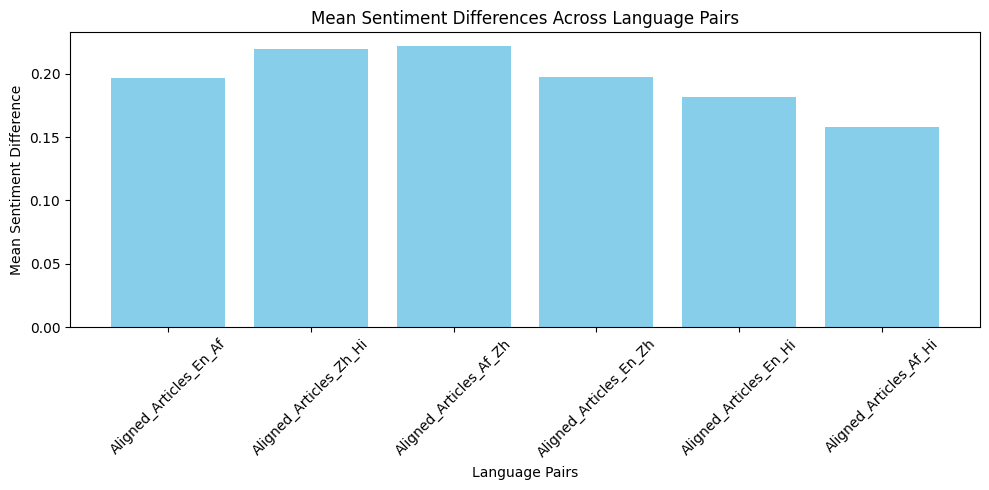

In [ ]:
def find_common_files(mock_folder):
    subfolder_files = []
    print("Finding common files...")
    for subfolder in os.listdir(mock_folder):
        subfolder_path = os.path.join(mock_folder, subfolder)
        print(f"Checking subfolder: {subfolder}")
        if os.path.isdir(subfolder_path):
            files = {file for file in os.listdir(subfolder_path) if file.endswith("_translated.txt")}
            # print(f"Files in {subfolder}: {files}")
            subfolder_files.append(files)

    common_files = set.intersection(*subfolder_files) if subfolder_files else set()
    # print(f"Common files across all subfolders: {common_files}")
    return common_files

def process_file(file_path):
    # print(f"Processing file: {file_path}")
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
        if not lines:
            print(f"No content in {file_path}")
            return None

        sentiment_differences = []

        for line in lines:
            if '---->' in line:
                left_sent, right_sent = line.split('---->')
                # Continue processing here
                # print(f"Processing line: {line.strip()}")
                encoded_left = tokenizer(left_sent, return_tensors='pt')
                encoded_right = tokenizer(right_sent, return_tensors='pt')

                output_left = model(**encoded_left)
                output_right = model(**encoded_right)

                # Get the maximum sentiment class
                left_pred = output_left[0].argmax().item()
                right_pred = output_right[0].argmax().item()

                # Check if sentiments differ
                sentiment_differences.append(1 if left_pred != right_pred else 0)



        if sentiment_differences:
            mean_difference = sum(sentiment_differences) / len(sentiment_differences)
            return mean_difference
        return 0
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

def process_subfolder(subfolder_path, common_files):
    print(f"Processing subfolder: {subfolder_path}")
    differences = []
    for file in os.listdir(subfolder_path):
        if file in common_files:
            result = process_file(os.path.join(subfolder_path, file))
            if result is not None:
                differences.append(result)

    if differences:
        return sum(differences) / len(differences)
    return 0

def main():
    # print("Starting main function...")
    mock_folder = '/content/drive/MyDrive/thesis-data/Translated_Articles-LASER2-final'
    common_files = find_common_files(mock_folder)
    results = {}

    for subfolder in os.listdir(mock_folder):
        subfolder_path = os.path.join(mock_folder, subfolder)
        # print(f"Found subfolder: {subfolder}")
        if os.path.isdir(subfolder_path):
            mean_difference = process_subfolder(subfolder_path, common_files)
            results[subfolder] = mean_difference
            print(f"Mean sentiment difference for {subfolder}: {mean_difference:.4f}")

    # Plotting code omitted for clarity
    # Add here if needed
    subfolders, mean_differences = zip(*results.items())
    plt.figure(figsize=(10, 5))
    plt.bar(subfolders, mean_differences, color='skyblue')
    plt.xlabel('Language Pairs')
    plt.ylabel('Mean Sentiment Difference')
    plt.title('Mean Sentiment Differences Across Language Pairs')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()


## ***War Issues Result***

Finding common files...
Checking subfolder: Aligned_Articles_Af_Zh
Checking subfolder: Aligned_Articles_En_Af
Checking subfolder: Aligned_Articles_Zh_Hi
Checking subfolder: Aligned_Articles_En_Zh
Checking subfolder: Aligned_Articles_En_Hi
Checking subfolder: Aligned_Articles_Af_Hi
Processing subfolder: /content/drive/MyDrive/thesis-data/war_files/Aligned_Articles_Af_Zh
Mean sentiment difference for Aligned_Articles_Af_Zh: 0.2897
Processing subfolder: /content/drive/MyDrive/thesis-data/war_files/Aligned_Articles_En_Af
Mean sentiment difference for Aligned_Articles_En_Af: 0.2310
Processing subfolder: /content/drive/MyDrive/thesis-data/war_files/Aligned_Articles_Zh_Hi
Mean sentiment difference for Aligned_Articles_Zh_Hi: 0.2157
Processing subfolder: /content/drive/MyDrive/thesis-data/war_files/Aligned_Articles_En_Zh
Mean sentiment difference for Aligned_Articles_En_Zh: 0.2724
Processing subfolder: /content/drive/MyDrive/thesis-data/war_files/Aligned_Articles_En_Hi
Mean sentiment differenc

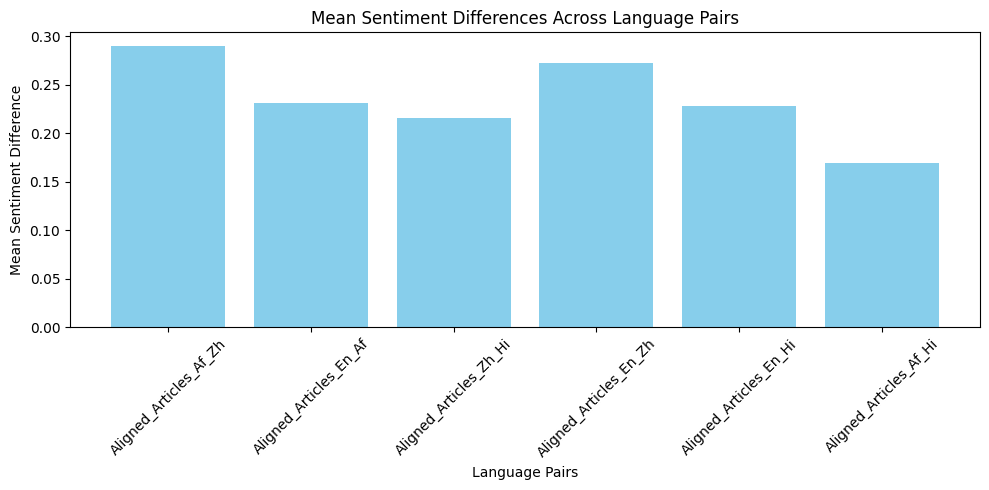

In [ ]:
def find_common_files(mock_folder):
    subfolder_files = []
    print("Finding common files...")
    for subfolder in os.listdir(mock_folder):
        subfolder_path = os.path.join(mock_folder, subfolder)
        print(f"Checking subfolder: {subfolder}")
        if os.path.isdir(subfolder_path):
            files = {file for file in os.listdir(subfolder_path) if file.endswith("_translated.txt")}
            # print(f"Files in {subfolder}: {files}")
            subfolder_files.append(files)

    common_files = set.intersection(*subfolder_files) if subfolder_files else set()
    # print(f"Common files across all subfolders: {common_files}")
    return common_files

def process_file(file_path):
    # print(f"Processing file: {file_path}")
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
        if not lines:
            print(f"No content in {file_path}")
            return None

        sentiment_differences = []

        for line in lines:
            if '---->' in line:
                left_sent, right_sent = line.split('---->')
                # Continue processing here
                # print(f"Processing line: {line.strip()}")
                encoded_left = tokenizer(left_sent, return_tensors='pt')
                encoded_right = tokenizer(right_sent, return_tensors='pt')

                output_left = model(**encoded_left)
                output_right = model(**encoded_right)

                # Get the maximum sentiment class
                left_pred = output_left[0].argmax().item()
                right_pred = output_right[0].argmax().item()

                # Check if sentiments differ
                sentiment_differences.append(1 if left_pred != right_pred else 0)



        if sentiment_differences:
            mean_difference = sum(sentiment_differences) / len(sentiment_differences)
            return mean_difference
        return 0
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

def process_subfolder(subfolder_path, common_files):
    print(f"Processing subfolder: {subfolder_path}")
    differences = []
    for file in os.listdir(subfolder_path):
        if file in common_files:
            result = process_file(os.path.join(subfolder_path, file))
            if result is not None:
                differences.append(result)

    if differences:
        return sum(differences) / len(differences)
    return 0

def main():
    # print("Starting main function...")
    mock_folder = '/content/drive/MyDrive/thesis-data/war_files'
    common_files = find_common_files(mock_folder)
    results = {}

    for subfolder in os.listdir(mock_folder):
        subfolder_path = os.path.join(mock_folder, subfolder)
        # print(f"Found subfolder: {subfolder}")
        if os.path.isdir(subfolder_path):
            mean_difference = process_subfolder(subfolder_path, common_files)
            results[subfolder] = mean_difference
            print(f"Mean sentiment difference for {subfolder}: {mean_difference:.4f}")

    # Plotting code omitted for clarity
    # Add here if needed
    subfolders, mean_differences = zip(*results.items())
    plt.figure(figsize=(10, 5))
    plt.bar(subfolders, mean_differences, color='skyblue')
    plt.xlabel('Language Pairs')
    plt.ylabel('Mean Sentiment Difference')
    plt.title('Mean Sentiment Differences Across Language Pairs')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()


## ***Controversial Issues List***

Finding common files...
Checking subfolder: Aligned_Articles_Af_Zh
Checking subfolder: Aligned_Articles_En_Af
Checking subfolder: Aligned_Articles_Zh_Hi
Checking subfolder: Aligned_Articles_En_Zh
Checking subfolder: Aligned_Articles_En_Hi
Checking subfolder: Aligned_Articles_Af_Hi
Processing subfolder: /content/drive/MyDrive/thesis-data/controv_files/Aligned_Articles_Af_Zh
Mean sentiment difference for Aligned_Articles_Af_Zh: 0.2158
Processing subfolder: /content/drive/MyDrive/thesis-data/controv_files/Aligned_Articles_En_Af
Mean sentiment difference for Aligned_Articles_En_Af: 0.1969
Processing subfolder: /content/drive/MyDrive/thesis-data/controv_files/Aligned_Articles_Zh_Hi
Mean sentiment difference for Aligned_Articles_Zh_Hi: 0.2198
Processing subfolder: /content/drive/MyDrive/thesis-data/controv_files/Aligned_Articles_En_Zh
Mean sentiment difference for Aligned_Articles_En_Zh: 0.1946
Processing subfolder: /content/drive/MyDrive/thesis-data/controv_files/Aligned_Articles_En_Hi
Mean

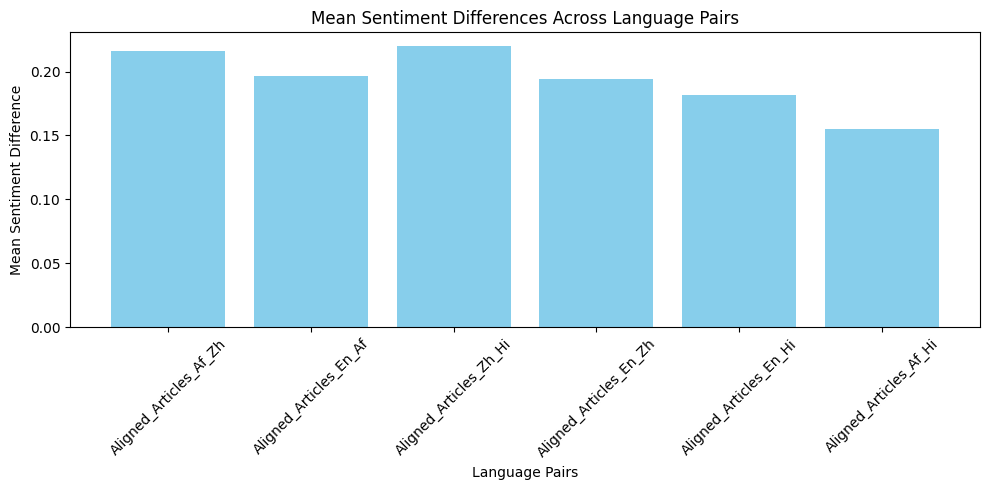

In [ ]:
def find_common_files(mock_folder):
    subfolder_files = []
    print("Finding common files...")
    for subfolder in os.listdir(mock_folder):
        subfolder_path = os.path.join(mock_folder, subfolder)
        print(f"Checking subfolder: {subfolder}")
        if os.path.isdir(subfolder_path):
            files = {file for file in os.listdir(subfolder_path) if file.endswith("_translated.txt")}
            # print(f"Files in {subfolder}: {files}")
            subfolder_files.append(files)

    common_files = set.intersection(*subfolder_files) if subfolder_files else set()
    # print(f"Common files across all subfolders: {common_files}")
    return common_files

def process_file(file_path):
    # print(f"Processing file: {file_path}")
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
        if not lines:
            print(f"No content in {file_path}")
            return None

        sentiment_differences = []

        for line in lines:
            if '---->' in line:
                left_sent, right_sent = line.split('---->')
                # Continue processing here
                # print(f"Processing line: {line.strip()}")
                encoded_left = tokenizer(left_sent, return_tensors='pt')
                encoded_right = tokenizer(right_sent, return_tensors='pt')

                output_left = model(**encoded_left)
                output_right = model(**encoded_right)

                # Get the maximum sentiment class
                left_pred = output_left[0].argmax().item()
                right_pred = output_right[0].argmax().item()

                # Check if sentiments differ
                sentiment_differences.append(1 if left_pred != right_pred else 0)



        if sentiment_differences:
            mean_difference = sum(sentiment_differences) / len(sentiment_differences)
            return mean_difference
        return 0
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

def process_subfolder(subfolder_path, common_files):
    print(f"Processing subfolder: {subfolder_path}")
    differences = []
    for file in os.listdir(subfolder_path):
        if file in common_files:
            result = process_file(os.path.join(subfolder_path, file))
            if result is not None:
                differences.append(result)

    if differences:
        return sum(differences) / len(differences)
    return 0

def main():
    # print("Starting main function...")
    mock_folder = '/content/drive/MyDrive/thesis-data/controv_files'
    common_files = find_common_files(mock_folder)
    results = {}

    for subfolder in os.listdir(mock_folder):
        subfolder_path = os.path.join(mock_folder, subfolder)
        # print(f"Found subfolder: {subfolder}")
        if os.path.isdir(subfolder_path):
            mean_difference = process_subfolder(subfolder_path, common_files)
            results[subfolder] = mean_difference
            print(f"Mean sentiment difference for {subfolder}: {mean_difference:.4f}")

    # Plotting code omitted for clarity
    # Add here if needed
    subfolders, mean_differences = zip(*results.items())
    plt.figure(figsize=(10, 5))
    plt.bar(subfolders, mean_differences, color='skyblue')
    plt.xlabel('Language Pairs')
    plt.ylabel('Mean Sentiment Difference')
    plt.title('Mean Sentiment Differences Across Language Pairs')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()


## **Without Document Boundary**

## ***Overall Results***

In [ ]:
# def main():
#     mock_folder = '/content/drive/MyDrive/thesis-data/Translated_Articles-LASER2-final'

#     for subfolder in os.listdir(mock_folder):
#         subfolder_path = os.path.join(mock_folder, subfolder)
#         if os.path.isdir(subfolder_path):
#             proportion_differing = process_subfolder(subfolder_path)
#             print(f"Proportion of differing sentiment pairs in {subfolder}: {proportion_differing:.4f}")

# if __name__ == "__main__":
#     main()


In [ ]:
import os
import csv
import urllib.request
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Define global variables for the model
task = 'sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

def find_common_files(base_folder):
    subfolder_files = []
    for subfolder in os.listdir(base_folder):
        subfolder_path = os.path.join(base_folder, subfolder)
        if os.path.isdir(subfolder_path):
            files = {file for file in os.listdir(subfolder_path) if file.endswith("_translated.txt")}
            if files:
                subfolder_files.append(files)
    return set.intersection(*subfolder_files) if subfolder_files else set()

def process_file(file_path):
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()

        differing_pairs = 0
        total_pairs = 0  # Initialize the count of total sentence pairs

        for line in lines:
            if '---->' in line:
                total_pairs += 1  # Increment for each sentence pair found
                left_sent, right_sent = line.split('---->')

                encoded_left = tokenizer(left_sent, return_tensors='pt')
                encoded_right = tokenizer(right_sent, return_tensors='pt')

                output_left = model(**encoded_left)
                output_right = model(**encoded_right)

                left_pred = output_left[0].argmax().item()
                right_pred = output_right[0].argmax().item()

                if left_pred != right_pred:
                    differing_pairs += 1

        return differing_pairs, total_pairs
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

def process_subfolder(subfolder_path, common_files):
    total_pairs = 0
    differing_pairs = 0

    for file in os.listdir(subfolder_path):
        if file in common_files:
            file_path = os.path.join(subfolder_path, file)
            file_results = process_file(file_path)
            if file_results:
                diff_pairs, total = file_results
                differing_pairs += diff_pairs
                total_pairs += total

    if total_pairs > 0:
        proportion_differing = differing_pairs / total_pairs
    else:
        proportion_differing = 0

    return proportion_differing

def main():
    mock_folder = '/content/drive/MyDrive/thesis-data/Translated_Articles-LASER2-final'
    common_files = find_common_files(mock_folder)  # Get common files across all subfolders

    for subfolder in os.listdir(mock_folder):
        subfolder_path = os.path.join(mock_folder, subfolder)
        if os.path.isdir(subfolder_path):
            proportion_differing = process_subfolder(subfolder_path, common_files)
            print(f"Proportion of differing sentiment pairs in {subfolder}: {proportion_differing:.4f}")

if __name__ == "__main__":
    main()


Proportion of differing sentiment pairs in Aligned_Articles_En_Af: 0.1901
Proportion of differing sentiment pairs in Aligned_Articles_Zh_Hi: 0.2229
Proportion of differing sentiment pairs in Aligned_Articles_Af_Zh: 0.2480
Proportion of differing sentiment pairs in Aligned_Articles_En_Zh: 0.1814
Proportion of differing sentiment pairs in Aligned_Articles_En_Hi: 0.1655
Proportion of differing sentiment pairs in Aligned_Articles_Af_Hi: 0.1857


## ***War Results***

In [ ]:
# def main():
#     mock_folder = '/content/drive/MyDrive/thesis-data/war_files'

#     for subfolder in os.listdir(mock_folder):
#         subfolder_path = os.path.join(mock_folder, subfolder)
#         if os.path.isdir(subfolder_path):
#             proportion_differing = process_subfolder(subfolder_path)
#             print(f"Proportion of differing sentiment pairs (Wars) in {subfolder}: {proportion_differing:.4f}")

# if __name__ == "__main__":
#     main()


In [ ]:
import os
import csv
import urllib.request
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Define global variables for the model
task = 'sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

def find_common_files(base_folder):
    subfolder_files = []
    for subfolder in os.listdir(base_folder):
        subfolder_path = os.path.join(base_folder, subfolder)
        if os.path.isdir(subfolder_path):
            files = {file for file in os.listdir(subfolder_path) if file.endswith("_translated.txt")}
            if files:
                subfolder_files.append(files)
    return set.intersection(*subfolder_files) if subfolder_files else set()

def process_file(file_path):
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()

        differing_pairs = 0
        total_pairs = 0  # Initialize the count of total sentence pairs

        for line in lines:
            if '---->' in line:
                total_pairs += 1  # Increment for each sentence pair found
                left_sent, right_sent = line.split('---->')

                encoded_left = tokenizer(left_sent, return_tensors='pt')
                encoded_right = tokenizer(right_sent, return_tensors='pt')

                output_left = model(**encoded_left)
                output_right = model(**encoded_right)

                left_pred = output_left[0].argmax().item()
                right_pred = output_right[0].argmax().item()

                if left_pred != right_pred:
                    differing_pairs += 1

        return differing_pairs, total_pairs
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

def process_subfolder(subfolder_path, common_files):
    total_pairs = 0
    differing_pairs = 0

    for file in os.listdir(subfolder_path):
        if file in common_files:
            file_path = os.path.join(subfolder_path, file)
            file_results = process_file(file_path)
            if file_results:
                diff_pairs, total = file_results
                differing_pairs += diff_pairs
                total_pairs += total

    if total_pairs > 0:
        proportion_differing = differing_pairs / total_pairs
    else:
        proportion_differing = 0

    return proportion_differing

def main():
    mock_folder = '/content/drive/MyDrive/thesis-data/war_files'
    common_files = find_common_files(mock_folder)  # Get common files across all subfolders

    for subfolder in os.listdir(mock_folder):
        subfolder_path = os.path.join(mock_folder, subfolder)
        if os.path.isdir(subfolder_path):
            proportion_differing = process_subfolder(subfolder_path, common_files)
            print(f"Proportion of differing sentiment pairs in {subfolder}: {proportion_differing:.4f}")

if __name__ == "__main__":
    main()


Proportion of differing sentiment pairs in Aligned_Articles_Af_Zh: 0.3222
Proportion of differing sentiment pairs in Aligned_Articles_En_Af: 0.2558
Proportion of differing sentiment pairs in Aligned_Articles_Zh_Hi: 0.2639
Proportion of differing sentiment pairs in Aligned_Articles_En_Zh: 0.2719
Proportion of differing sentiment pairs in Aligned_Articles_En_Hi: 0.2500
Proportion of differing sentiment pairs in Aligned_Articles_Af_Hi: 0.2500


## ***Controversial Results***

In [ ]:
# def main():
#     mock_folder = '/content/drive/MyDrive/thesis-data/controv_files'

#     for subfolder in os.listdir(mock_folder):
#         subfolder_path = os.path.join(mock_folder, subfolder)
#         if os.path.isdir(subfolder_path):
#             proportion_differing = process_subfolder(subfolder_path)
#             print(f"Proportion of differing sentiment pairs (Controversial) in {subfolder}: {proportion_differing:.4f}")

# if __name__ == "__main__":
#     main()


In [ ]:
import os
import csv
import urllib.request
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Define global variables for the model
task = 'sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

def find_common_files(base_folder):
    subfolder_files = []
    for subfolder in os.listdir(base_folder):
        subfolder_path = os.path.join(base_folder, subfolder)
        if os.path.isdir(subfolder_path):
            files = {file for file in os.listdir(subfolder_path) if file.endswith("_translated.txt")}
            if files:
                subfolder_files.append(files)
    return set.intersection(*subfolder_files) if subfolder_files else set()

def process_file(file_path):
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()

        differing_pairs = 0
        total_pairs = 0  # Initialize the count of total sentence pairs

        for line in lines:
            if '---->' in line:
                total_pairs += 1  # Increment for each sentence pair found
                left_sent, right_sent = line.split('---->')

                encoded_left = tokenizer(left_sent, return_tensors='pt')
                encoded_right = tokenizer(right_sent, return_tensors='pt')

                output_left = model(**encoded_left)
                output_right = model(**encoded_right)

                left_pred = output_left[0].argmax().item()
                right_pred = output_right[0].argmax().item()

                if left_pred != right_pred:
                    differing_pairs += 1

        return differing_pairs, total_pairs
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

def process_subfolder(subfolder_path, common_files):
    total_pairs = 0
    differing_pairs = 0

    for file in os.listdir(subfolder_path):
        if file in common_files:
            file_path = os.path.join(subfolder_path, file)
            file_results = process_file(file_path)
            if file_results:
                diff_pairs, total = file_results
                differing_pairs += diff_pairs
                total_pairs += total

    if total_pairs > 0:
        proportion_differing = differing_pairs / total_pairs
    else:
        proportion_differing = 0

    return proportion_differing

def main():
    mock_folder = '/content/drive/MyDrive/thesis-data/controv_files'
    common_files = find_common_files(mock_folder)  # Get common files across all subfolders

    for subfolder in os.listdir(mock_folder):
        subfolder_path = os.path.join(mock_folder, subfolder)
        if os.path.isdir(subfolder_path):
            proportion_differing = process_subfolder(subfolder_path, common_files)
            print(f"Proportion of differing sentiment pairs in {subfolder}: {proportion_differing:.4f}")

if __name__ == "__main__":
    main()


Proportion of differing sentiment pairs in Aligned_Articles_Af_Zh: 0.2403
Proportion of differing sentiment pairs in Aligned_Articles_En_Af: 0.1854
Proportion of differing sentiment pairs in Aligned_Articles_Zh_Hi: 0.2191
Proportion of differing sentiment pairs in Aligned_Articles_En_Zh: 0.1749
Proportion of differing sentiment pairs in Aligned_Articles_En_Hi: 0.1634
Proportion of differing sentiment pairs in Aligned_Articles_Af_Hi: 0.1795


In [ ]:
import pandas as pd

# Create a DataFrame with your data
data = {
    'Language Pair': ['English-Afrikaans', 'Chinese-Hindi', 'Afrikaans-Chinese', 'English-Chinese', 'English-Hindi', 'Afrikaans-Hindi'],
    'Model Results': [0.6, 0.5, 0.7, 0.7, 0.63, 0.6],
    'Human Results': [0.6, 0.35, 0.5, 0.5, 0.43, 0.6]
}

df = pd.DataFrame(data)

# Calculate the Pearson correlation coefficient
correlation = df['Model Results'].corr(df['Human Results'])
print("Pearson correlation coefficient:", correlation)


Pearson correlation coefficient: 0.36570497155117276


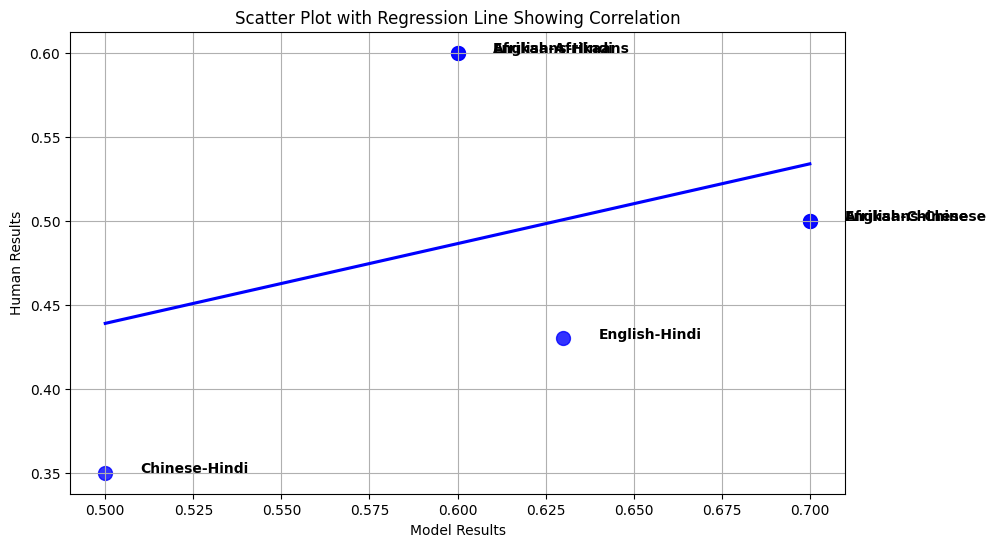

In [ ]:
plt.figure(figsize=(10, 6))
sns.regplot(x='Model Results', y='Human Results', data=df, scatter_kws={'s':100}, ci=None, color='blue')

# Adding annotations for each point
for i in range(df.shape[0]):
    plt.text(df.loc[i, 'Model Results'] + 0.01, df.loc[i, 'Human Results'], df.loc[i, 'Language Pair'],
             horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.title('Scatter Plot with Regression Line Showing Correlation')
plt.xlabel('Model Results')
plt.ylabel('Human Results')
plt.grid(True)
plt.show()
